In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Deep Learning Imports
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, RepeatVector, TimeDistributed, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import random
import os

# --- GOD MODE: FREEZE RANDOMNESS ---
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("Randomness frozen. Results will be reproducible.")

Randomness frozen. Results will be reproducible.


In [2]:
# 1. Load Data
print("Loading datasets...")
try:
    train_df = pd.read_csv('UNSW_NB15_training-set.csv')
    test_df = pd.read_csv('UNSW_NB15_testing-set.csv')
except FileNotFoundError:
    print("ERROR: Files not found. Please upload UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv")

# 2. Drop ID columns
if 'id' in train_df.columns: train_df = train_df.drop('id', axis=1)
if 'id' in test_df.columns: test_df = test_df.drop('id', axis=1)

# 3. Separate Labels
y_train = train_df['label']
y_test = test_df['label']

# 4. Drop Label columns for feature processing
X_train_raw = train_df.drop(['label', 'attack_cat'], axis=1)
X_test_raw = test_df.drop(['label', 'attack_cat'], axis=1)

# 5. Combine for consistent One-Hot Encoding
combined_df = pd.concat([X_train_raw, X_test_raw], axis=0)
combined_df = pd.get_dummies(combined_df)

# 6. Split back into train and test
X_train_encoded = combined_df.iloc[:len(train_df)]
X_test_encoded = combined_df.iloc[len(train_df):]

# 7. Scale Data (MinMax)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert to float32 to save RAM
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

print("Data Loaded & Scaled.")
print(f"Training Shape: {X_train_scaled.shape}")

Loading datasets...
Data Loaded & Scaled.
Training Shape: (29792, 195)


In [3]:
# --- PILLAR 1: OPTIMAL DATA VIEW ---
TIME_STEPS = 10  # Window Size

def create_sequences(data, labels, time_steps=TIME_STEPS):
    sequences = []
    seq_labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
        seq_labels.append(labels.iloc[i + time_steps])
    return np.array(sequences), np.array(seq_labels)

print(f"Creating sequences with {TIME_STEPS} steps...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIME_STEPS)

# FILTER: Train ONLY on Normal traffic (Label = 0)
X_train_normal = X_train_seq[y_train_seq == 0]

print(f"Total Training Sequences: {X_train_seq.shape}")
print(f"Normal Training Sequences (used for Autoencoder): {X_train_normal.shape}")

Creating sequences with 10 steps...
Total Training Sequences: (29782, 10, 195)
Normal Training Sequences (used for Autoencoder): (6664, 10, 195)


In [4]:
n_features = X_train_seq.shape[2]

# --- PILLAR 2: ROBUST ARCHITECTURE ---
model = Sequential([
    Input(shape=(TIME_STEPS, n_features)),

    # 1. Feature Extraction (CNN)
    # 128 filters to catch more patterns
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(), # Stabilizes math
    Dropout(0.2),

    # 2. Context Understanding (Encoder)
    # Bidirectional lets it see "Future" context
    Bidirectional(LSTM(64, activation='tanh', return_sequences=False)),

    # 3. Latent Space (Bottleneck)
    RepeatVector(TIME_STEPS),

    # 4. Reconstruction (Decoder)
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.2),

    # 5. Output Layer
    TimeDistributed(Dense(n_features))
])

# Slower learning rate for precision
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 128)        │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 195)        │        25,155 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,307 (1.14 MB)

 Trainable params: 298,051 (1.14 MB)

 Non-trainable params: 256 (1.00 KB)

Starting Training...
Epoch 1/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0321
Epoch 1: val_loss improved from inf to 0.02063, saving model to best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0320 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 2/60
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166
Epoch 2: val_loss improved from 0.02063 to 0.01593, saving model to best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0165 - val_loss: 0.0159 - learning_rate: 1.0000e-04
Epoch 3/60
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138
Epoch 3: val_loss improved from 0.01593 to 0.01261, saving model to best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0137 - val_loss: 0.0126 - learning_rate: 1.0000e-04
Epoch 4/60
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0127
Epoch 4: val_loss improved from 0.01261 to 0.01079, saving model to best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0127 - val_loss: 0.010

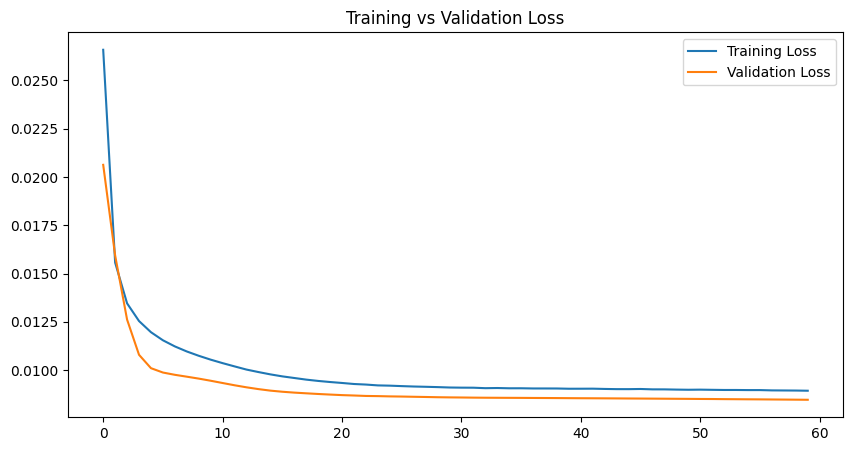

In [5]:
# --- PILLAR 3: SMART TRAINING ---

# 1. Save the BEST weights (not the last ones)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# 2. Stop if no improvement for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 3. Slow down learning rate if stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

print("Starting Training...")
history = model.fit(
    X_train_normal, X_train_normal,
    epochs=60,           # High ceiling, EarlyStopping will cut it short
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

# Plot Training History
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [9]:
X_train_anomalous = X_train_seq[y_train_seq == 1]
y_train_anomalous = y_train_seq[y_train_seq == 1]

print(f"Anomalous training sequences extracted: {X_train_anomalous.shape}")

Anomalous training sequences extracted: (23117, 10, 195)


In [10]:
X_combined_test_seq = np.concatenate([X_test_seq, X_train_anomalous], axis=0)
y_combined_test_seq = np.concatenate([y_test_seq, y_train_anomalous], axis=0)

# Remove NaN values from y_combined_test_seq and corresponding X_combined_test_seq
nan_mask = ~np.isnan(y_combined_test_seq)
X_combined_test_seq = X_combined_test_seq[nan_mask]
y_combined_test_seq = y_combined_test_seq[nan_mask]

print(f"Combined test sequences shape: {X_combined_test_seq.shape}")
print(f"Combined test labels shape: {y_combined_test_seq.shape}")

Combined test sequences shape: (58311, 10, 195)
Combined test labels shape: (58311,)


Predicting on combined test data...
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Calculating Reconstruction Error for combined test data...

Scanning for optimal threshold (maximizing F1 Score) on combined data...
--- OPTIMIZATION RESULTS FOR COMBINED DATA ---
Best Threshold: 0.03238
Best F1-Score: 0.9431

Confusion Matrix (Combined Data):
[[34317   877]
 [ 1707 21410]]

Classification Report (Combined Data):
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     35194
         1.0       0.96      0.93      0.94     23117

    accuracy                           0.96     58311
   macro avg       0.96      0.95      0.95     58311
weighted avg       0.96      0.96      0.96     58311



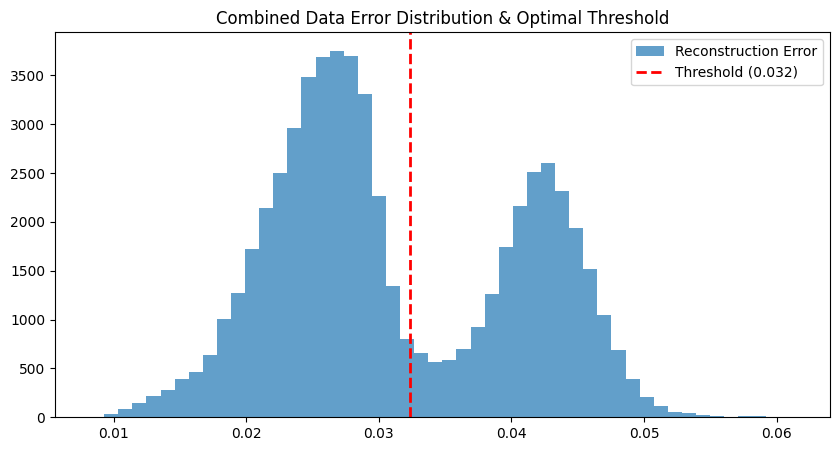

In [11]:
print("Predicting on combined test data...")
X_combined_test_pred = model.predict(X_combined_test_seq)

combined_test_mae_loss = []
BATCH_SIZE = 1000 # Use the same batch size as before for consistency
print("Calculating Reconstruction Error for combined test data...")
for i in range(0, len(X_combined_test_seq), BATCH_SIZE):
    batch_true = X_combined_test_seq[i : i + BATCH_SIZE]
    batch_pred = X_combined_test_pred[i : i + BATCH_SIZE]

    # Mean Absolute Error per sequence (average across time steps and features)
    batch_error = np.mean(np.abs(batch_pred - batch_true), axis=1)
    batch_error = np.mean(batch_error, axis=1)
    combined_test_mae_loss.extend(batch_error)

combined_test_mae_loss = np.array(combined_test_mae_loss)

# --- AUTOMATIC THRESHOLD FINDER FOR COMBINED DATA ---
print("\nScanning for optimal threshold (maximizing F1 Score) on combined data...")
thresholds = np.linspace(np.min(combined_test_mae_loss), np.max(combined_test_mae_loss), 100)
best_f1 = 0
best_thresh = 0

for thresh in thresholds:
    preds = (combined_test_mae_loss > thresh).astype(int)
    # Ensure y_combined_test_seq is not empty and has anomalies for F1-score calculation
    if len(y_combined_test_seq[y_combined_test_seq == 1]) > 0 and len(np.unique(y_combined_test_seq)) > 1:
        score = f1_score(y_combined_test_seq, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

print(f"--- OPTIMIZATION RESULTS FOR COMBINED DATA ---")
print(f"Best Threshold: {best_thresh:.5f}")
print(f"Best F1-Score: {best_f1:.4f}")

# --- Generate Final Report using Best Threshold ---
FINAL_THRESHOLD = best_thresh
predicted_labels_combined = (combined_test_mae_loss > FINAL_THRESHOLD).astype(int)

print("\nConfusion Matrix (Combined Data):")
print(confusion_matrix(y_combined_test_seq, predicted_labels_combined))

print("\nClassification Report (Combined Data):")
print(classification_report(y_combined_test_seq, predicted_labels_combined))

# --- Plot Final Histogram for Combined Data ---
plt.figure(figsize=(10,5))
plt.hist(combined_test_mae_loss, bins=50, alpha=0.7, label='Reconstruction Error')
plt.axvline(FINAL_THRESHOLD, color='r', linestyle='dashed', linewidth=2, label=f'Threshold ({FINAL_THRESHOLD:.3f})')
plt.title("Combined Data Error Distribution & Optimal Threshold")
plt.legend()
plt.show()